In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

We can retrieve the probability of events happening, e.g. x=3.0

In [ ]:
p_3 = norm.pdf(3.0, 5.0, 3.0)

We can also easily calculate the joint probability of iid (indepenent and identically distributed) events

In [ ]:
p_7 = norm.pdf(7.0, 7.0, 3.0)

joint = p_3*p_7

In [ ]:
p_3, p_7, joint

(0.10648266850745075, 0.1329807601338109, 0.014160146199197409)

Assume now that someone is giving us an array of values and ask us to estimate a pmodel that is a 'good fit' to the gievn data. How we can go about solving this problem with Maximum Likelihood Estimation (MLE)? Notice that as addressed in [3], probability and likelihood have a reverse relationship. Probability attaches to possible results; likelihood attaches to hypotheses. The likelihood function gives the relative likelihoods of different values for the parameter(s) of the distribution from which the data are assumed to have been drawn, given those data.

Lets plot a couple of pmodel hypotheses - the data are shown below in the same plot. Both hypotheses are plausible.

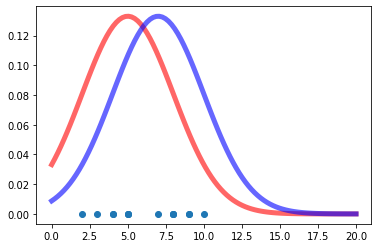

In [ ]:
data = [4, 5, 7, 8, 8, 9, 10, 5, 2, 3, 5, 4, 8, 9]

fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 20, 100)
ax.plot(x, norm.pdf(x,5,3),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(x, norm.pdf(x,7,3),
       'b-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(data, np.zeros(len(data)).tolist(),'o')

As detailed in Ref [2], its important to safeguard against underflow that may well result from multiplying many numbers (for large datasets) that are less than 1.0 (probabilities). So we do the calculations in the log domain using the identity

log(a×b)=log(a)+log(b) Lets look at a function that calculates the log-likelihood for the two hypotheses above given the data denoted by x.

In [ ]:
def compare_data_to_dist(x, mu_1=5, mu_2=7, sd_1=3, sd_2=3):
    ll_1 = 0
    ll_2 = 0
    for i in x:
        ll_1 += np.log(norm.pdf(i, mu_1, sd_1))
        ll_2 += np.log(norm.pdf(i, mu_2, sd_2))
    
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_1, sd_1, ll_1))
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_2, sd_2, ll_2))

We can readily compate the two hypotheses according to the maximum likelihood criterion. Note that because the log is a monotonic function, the conclusion as to which hypothesis makes the data more likely is the same in the natural or the log domain.

In [ ]:
ll_comparison = compare_data_to_dist(data)

The LL of of x for mu = 5 and sd = 3 is: -33.9679
The LL of of x for mu = 7 and sd = 3 is: -33.3013


It seems that the second hypothesis

pmodel(x|w)=N(x|[μ2,σ22]) is preferred compared to the first.

We can now start searching the hypothesis space (parameter space) for the best parameter set w.

The max LL for sd 0.50 is 167.88
The max LL for sd 1.50 is 36.84
The max LL for sd 2.50 is 32.28
The max LL for sd 3.50 is 33.77
The max LL for sd 4.50 is 35.96


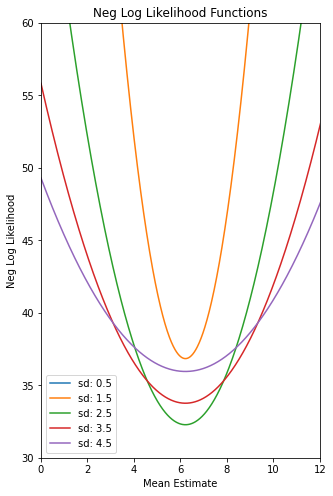

In [ ]:
# Plot the Negative Log Likelihood Functions for different values of mu 
# and sigma
def plot_ll(x):
    plt.figure(figsize=(5,8))
    plt.title("Neg Log Likelihood Functions")
    plt.xlabel("Mean Estimate")
    plt.ylabel("Neg Log Likelihood")
    plt.ylim(30, 60)
    plt.xlim(0, 12)
    mu_set = np.linspace(0, 16, 1000)
    sd_set = [.5, 1.5, 2.5, 3.5, 4.5]
    max_val = max_val_location = None
    for i in sd_set:
        ll_array = []
        
        for j in mu_set:
            temp_mm = 0
            
            for k in x:
                temp_mm += np.log(norm.pdf(k, j, i)) # The LL function
            ll_array.append(-temp_mm) # negative LL
        
            if (max_val is None):
                max_val = min(ll_array)
            elif max(ll_array) > max_val:
                max_val = min(ll_array)
                max_val_location = j
        
        # Plot the results
        plt.plot(mu_set, ll_array, label="sd: %.1f" % i)
        
        print("The max LL for sd %.2f is %.2f" % (i, min(ll_array)))    
    plt.axvline(x=max_val_location, color='black', ls='-.')
    plt.legend(loc='lower left')
plot_ll(data);

But there is a better method than exhaustively searching in the parameter space. We developed a method that incrementally minimizes a loss function that is ultimately linked to the concept of entropy - the cross entropy (CE) that for the supervided learning problem as shown in the notes has a lot to do with minimizing the KL divergence - a type of probabilistic 'distance' between p̂ data and pmodel.

This method is the Stochastic Gradient Descent. Can ypu estimate the hypothesis for the data array above?

Problem 1 - MLE
High level flow of the solution is as below

I will build a stochastic gradient descent method for MLE
I will then verify the SGD results against the theoretical solution

In [ ]:
# Importing few libraries which will come handy when later used
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import time
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

Problem 1 - Approach taken
Task as I understood here is to find the best mean and standard deviation that will give maximum likelihood that the data samples provided are from the normal distribution of this best mean and Standard Deviation.

The steps that I would follow for finding the optimum mean and standard deviation are as follows.
Get the function that provides the output we want to optimize, i.e. get the objective (or cost function) defined which in our case is negative log of probability density function. (refer to equation 3 in the attached document)

The job is to minimize this cost function (Equation 3)
Get the first partial derivatives against the parameters to calculate the gradients.

The unknown random variables here are mean and standard deviation
We get Equation 4 for partial derivative against mean and Equation 6 for partial derivative against Standard Deviation so that we can compute the gradients.

The flow of the code is

to start with the random values for mean and standard deviation or weights
to calculate the negative log likelihood for above random weights
to calculate the gradients against both weights
adjust the weights using the above gradients (note: during this adjustment we will be applying the learning rate, denoted by parameter learning_rate)
once we get new weights we can recheck the negative log likelihood
Our original objective was to minimize the negative log likelihood, so we will keep on checking this imrpovement in loop
the loop will run until the improvement is no more significant; here significant is defined by the variable tolerance
what if this loop runs for infinite times, thus we need to have another parameter n_iter, this is to keep capping on the number of iterations.
By applying the above we will be able to implement gradient descent, but the task was to built stochastic gradient descent.
Lastly we will not adjust the weights for all the datapoints in one go, rather to make it stochastic gradient descent we will define a variable batch_size which will control the number of observations to process a change in weights.

Function neg_log_likelihood
This function is to take a data list, mean, standard deviation and calculates the negative log likelihood
Negative log likelihood here is proxy measure of how likely it is that this data list is a samples collected from a
normal distrubition having provided mean and standard deviation.

In [ ]:
def neg_log_likelihood(data, mean, std):
    # Note: I could have used the original formula for probability density function (equation 3) 
    # but as you had already used the norm.pdf in above codes so I am reusing the same.
    # Thus assume this to be implementation of equation 3
    
    return -sum([np.log(norm.pdf(x, mean, std)) for x in data])

Function gradient_mean
This is the implementation based on equation 4

In [ ]:
def gradient_mean(data, mean, std):
    # This function returns first partial derivative for mean i.e. gradient with respect to mean
    return -(sum([x - mean for x in data])/np.square(std))

Function gradient_std
This is the implementation based on equation 6

In [ ]:
def gradient_std(data, mean, std):
    # This function returns partial first derivative for standard deviation i.e. gradient with respect standard deviation
    return (len(data)/std - sum(np.square([x - mean for x in data]))/(std**3))

Function update_weights
This function is to adjust or say update the weights (mean and standard deviation) based on the gradients and learning rate
Thus function will return adjust mean and standard deviation

In [ ]:
def update_weights(data, mean, std, learning_rate):
    
    # new mean will be given by adjusting the previous mean by learning rate * gradient of mean
    new_mean = mean - learning_rate * gradient_mean(data, mean, std)
    
    # new mean will be given by adjusting the previous mean by learning rate * gradient of standard deviation
    new_std = std - learning_rate * gradient_std(data, mean, std)
    
    return new_mean, new_std

Function stocastic_gradient_descent
This function is to return the expected mean and expected standard deviation for the provided random numbers

In [ ]:
def stocastic_gradient_descent(data, n_iter = 1000, learning_rate = .1,batch_size = 14, tolerance = .0001):
    
    # Capture the start time of the SGD
    start_time = time.time()
    
    # Validate that there must be atleast 2 elements in the data
    if len(data) <= 1:
        raise ValueError('Re-Check the data list; it must have atleast 2 elements, processing ended !!!')
        
    # Initiazing the weights (i.e. mean and standard deviation)
    mean = std = np.random.randint(min(data),max(data)+1)
    
    # Capturing the initial negative log likelihood for the initialized weights
    previous_ll = neg_log_likelihood(data, mean, std)
    
    # counter is used for checking if for 10 continous iterations improvement is less than tolerance then end the loop
    counter = 0

    # Main loop for stocastic gradiend descent
    # It will run for n_iter or until there is an improvement >= tolerance
    for i in range(n_iter):
        
        # This is to loop through batches for SGD
        # Note that last batch size could be less than the expected batch size
        for j in range(0, len(data), batch_size):
            
            # Extracting the batch value for adjusting the weights
            batch = data[j:j+batch_size]
            
            # Based on the gradient get the adjusted new weights
            mean, std = update_weights(batch, mean, std, learning_rate)
        
        # Capture the new negative log likelihood for the adjusted weights
        ll = neg_log_likelihood(data, mean, std)
        
        # Capture the improvement in the negative log likelihood against the previous value
        change_in_ll = previous_ll - ll
        
        # Store the current negative log likelihood for next iteration
        previous_ll = ll
        
        print(f'For Epoch {i+1}, Negative Log Likelihood is {ll}')
        
        # Check if absolute improvement is less than tolerance
        # This check will make use of counter to see if for 10 continous loops there is no significant improvement 
        # then end the loop
        if (abs(change_in_ll) < tolerance): counter += 1
        else: counter = 0
        if counter == 10:
            break
    
    # Print statements to give insight of the processing being done by this fuction
    if i+1 < n_iter:
        print(f'Search cannot improve more than tolerance of {tolerance} in last 10 epochs \n')
        print(f"With a learning rate of {learning_rate} and {i+1} Epoch it took {str(round(time.time() - start_time, 3))} seconds for Stocastic Gradient descent to complete training \n")
    else:
        print(f'End of Epoch reached, try giving another learning rate for faster and better search \n')
        print(f"With a learning rate of {learning_rate} and {i+1} Epoch it took {str(round(time.time() - start_time, 3))} seconds for Stocastic Gradient descent to train \n")
    
    # Return the required mean and standard deviation for the population from which the sample data is most likely extracted
    return mean, std

In [ ]:
data

[4, 5, 7, 8, 8, 9, 10, 5, 2, 3, 5, 4, 8, 9]

Excuting the function stocastic_gradient_descent for our data

In [ ]:
population_mean, population_std = stocastic_gradient_descent(data, learning_rate=.1)
print(f'Population Mean is {population_mean} and Standard Deviation is {population_std}')

For Epoch 1, Negative Log Likelihood is 39.740896257108915
For Epoch 2, Negative Log Likelihood is 39.371083720957905
For Epoch 3, Negative Log Likelihood is 38.988861985613845
For Epoch 4, Negative Log Likelihood is 38.593842885479525
For Epoch 5, Negative Log Likelihood is 38.185787461377636
For Epoch 6, Negative Log Likelihood is 37.76468427585653
For Epoch 7, Negative Log Likelihood is 37.33085851763734
For Epoch 8, Negative Log Likelihood is 36.885121816637074
For Epoch 9, Negative Log Likelihood is 36.42897386511688
For Epoch 10, Negative Log Likelihood is 35.96486568921812
For Epoch 11, Negative Log Likelihood is 35.496527191417194
For Epoch 12, Negative Log Likelihood is 35.02934184661891
For Epoch 13, Negative Log Likelihood is 34.57070888908382
For Epoch 14, Negative Log Likelihood is 34.130256326399234
For Epoch 15, Negative Log Likelihood is 33.719656162881094
For Epoch 16, Negative Log Likelihood is 33.35169028354999
For Epoch 17, Negative Log Likelihood is 33.038261305276

Observation
By running the SGD we have found the mean and standard deviation which computes nimimum negative log likelihood for the data
The random numbers in data were most likely extacted using the normal distribution of Population mean 6.214 and standard deviation 2.425

Verifying SGD solution with theory
The stationary point where both partial derivatives will be zero gave us equation 5 and 7; as solution for best mean and standard deviation.

We can now check using equation 5 and 7 does this matches to the SGD solution for best weights

Theoritical best mean and standard deviation is derived and implemented here based on equation 5 and equation 7

In [ ]:
f'Theoritical best mean is {np.mean(data)} and standard deviation is {np.std(data)}'

'Theoritical best mean is 6.214285714285714 and standard deviation is 2.425418120907092'

Final conclusion
As both are matching now we can conclude by saying that the maximum likelihood estimation is given by the mean and standard deviation of the datapoints.

Problem 2 - Simple Linear Regression
High level flow of the solution is as below

We will perform few statistical tests on our data
We will implement gradient descent algorithm for simple linear regression
We will verify our gradient descent results with theoretical solution
We will verify the residual assumptions for linear regession
We will make use of OLS function summary to comment on the statistical datapoints.

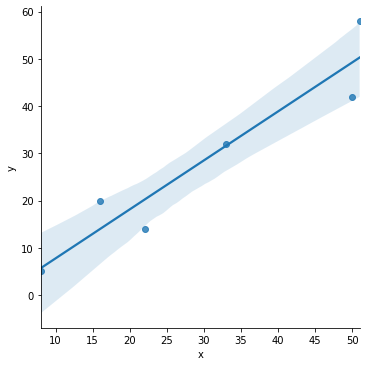

In [ ]:
x = np.array([8, 16, 22, 33, 50, 51])
y = np.array([5, 20, 14, 32, 42, 58])
df = pd.DataFrame({'x':x,'y':y})
g = sns.lmplot(x="x", y="y", data=df)

Linear Model Plot Observation

There seems to be positive high correlation between x and y

Normality Test
The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

Null Hypothesis
H0: The data is drawn from a normal distribution
Alternative Hypothesis
Ha: The data is not drawn from a normal distribution
alpha = 0.05

In [ ]:
print(stats.shapiro(x))
print(stats.shapiro(y))

(0.9136742949485779, 0.4610065817832947)
(0.9732536673545837, 0.9135345816612244)


Normality Test Observation

For variable x and y p-value is greater than level of significance thus we will accept the null hypothesis; i.e. we can assume that both x and y are drawn from the population of normal distribution.

Homogeniety Test
The Levene test tests the null hypothesis that all input samples are from populations with equal variances.

Null Hypothesis
H0: All input samples are from populations with equal variances
Alternative Hypothesis
Ha: Atleast one input samples populations variances is different
alpha = 0.05

In [ ]:
print(stats.levene(x,y))

LeveneResult(statistic=0.024910322837784018, pvalue=0.8777322335671627)


Homogeniety Test Observation

For groups of x and y p-value is greater than level of significance thus we will accept the null hypothesis; i.e. we can assume that both x and y are drawn from the population of equal variances

## Simple Linear Regression Assumption

It is assumed that y and x have a linear relationship and in order to get that relationship we will work on simple linear regression using gradient descent.



## Approach for Gradient Descent Method

1. In this method the error is represented in squared form i.e.  E =  (Yexpected – Ypred)^2
2. Expanding Ypred,   E =  ((Yexpected – (mX + C))^2  
3. Thus, E is a function of  m and c given Yexpected and X come from data
4. The E function being quadratic (raised to power of 2) when plotted against m and c, will acquire a parabolic shape
5. This guarantees an absolute minima i.e. there will be a unique combination of m and c which will deliver the least error. Let this be the best m and best c
6. Starting from some random m and c, the Gradient Descent method will automatically discover the best m and best c using a mathematical technique called “Partial Derivatives”
7. This method can be applied with any number of independent variables.

Function gradient
This function will calculate the partial first derivative of the cost function for each parameter of the simple linear regression

In [ ]:
def gradient(x, y, b):
    # First we will calculate the residual based on the current parameter values
    residual = b[0] + b[1] * x - y
    
    # We are returning the partial first derivatives as explained in the eq 4 and eq 5 in the above picture.
    return -2*(residual.sum()), -2*((residual * x).sum())

Function gradient_descent
This function will calculate the best parameter values using the gradient descent

In [ ]:
def gradient_descent(x, y, start=[0.5, 0.5], learning_rate=0.001, n_iter=100000, tolerance=1e-06):

    # Setting up the data type for NumPy arrays
    dtype_ = np.dtype("float64")

    # Change x and y arrays as Numpy arrays and validating that length of both x and y must be same
    x, y = np.array(x, dtype=dtype_), np.array(y, dtype=dtype_)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Arrays x and y should have same length")

    # coef will contain the parameters of equation and we need to initialize the values as start
    coef = np.array(start, dtype=dtype_)

    # Validating learning rate must be positive
    if learning_rate <= 0:
        raise ValueError("'learning_rate' must be positive number")

    # Validating number of iterations must be positive
    n_iter = int(n_iter)
    if n_iter <= 0:
        raise ValueError("'n_iter' must be positive number")

    # Validating tolerance must be positive
    if np.any(tolerance <= 0):
        raise ValueError("'tolerance' must be positive number")

    # Main Loop for performing gradient descent
    # It will run for n_iter or until the improvement is not greater than tolerance
    for i in range(n_iter):
        
        # Check how much change in parameter is needed based on gradient
        diff = learning_rate * np.array(gradient(x, y, coef), dtype_)
        
        # Check if the absolute difference is small enough to break the loop
        if np.all(np.abs(diff) <= tolerance):
            break

        # Updating the values of the coefficients
        coef += diff

    return coef

Calling function gradient_descent for our data points x and y

In [ ]:
b0, b1 = gradient_descent(x, y, start=[1, 1], learning_rate=0.0001, n_iter=1000000, tolerance=1e-09)
print(f'Relationship between x and y is given by the linear equation --> y = {round(b1,4)}*x + {round(b0,4)}')

Relationship between x and y is given by the linear equation --> y = 1.0364*x + -2.5916


Verifying gradient descent solution with theory
Here we are calulating the best intercept and coef of x by derived formula eq 2 and eq 3 in the theory (page 2).

In [ ]:
#storing y_ and x_ as ybar and xbar representing the means of y and x
y_ = y.mean()
x_ = x.mean()

# This is the implementation of stationary points by evaluating patial derivatives to zero

# Implementation of equation 2
best_b1 = np.sum((y-y_)*(x-x_))/np.sum((x-x_)**2)

# Implementation of equation 3
best_b0 = y_ - best_b1 * x_

print(f'Relationship between x and y is given by the linear equation --> y = {round(best_b1,4)}*x + {round(best_b0,4)}')

Relationship between x and y is given by the linear equation --> y = 1.0364*x + -2.5916


Verification result
Simple linear regression relationship of y and x is same between theory result and the gradient descent result.
The relationship is as below -

y = 1.0364 * x - 2.5916